In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install dan Import Library :

In [2]:
!pip install optuna

In [3]:
!pip install gensim

In [4]:
import optuna
import pandas as pd
import numpy as np
import gensim
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# Load Dataset :

In [5]:
file_path = "/content/drive/MyDrive/DistilBERT-7-Mei/combined_dataset.csv"
df = pd.read_csv(file_path)
print(df.head())

   Unnamed: 0         Label  \
0           0  Non-bullying   
1           1  Non-bullying   
2           2      Bullying   
3           3  Non-bullying   
4           4  Non-bullying   

                                          clean_text  \
0       kaka tidur yaa sudah pagi tidak boleh capek2   
1                    makan nasi padang saja badannya   
2                         suka cukur jembut manggung   
3  hai kak isyana ngefans sekali kak isyana suka ...   
4             manusia bidadari sih herann deh cantik   

                                              String  encoded_label  
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"            1.0  
1            "makan nasi padang aja begini badannya"            1.0  
2  "yang aku suka dari dia adalah selalu cukur je...            0.0  
3  "Hai kak Isyana aku ngefans banget sama kak Is...            1.0  
4  "Manusia apa bidadari sih herann deh cantik te...            1.0  


In [6]:
print(df.shape)

(2066, 5)


# Train-Test Split :

In [7]:
X = df['clean_text'].astype(str)
y = df['encoded_label']

# LabelEncoder untuk nama kelas
le = LabelEncoder()
le.fit(df['Label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Tokenisasi dan Padding :

In [8]:
max_words = 20000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Download dan Extract file pre-trained embedding FastText :

In [9]:
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz

--2025-09-30 08:04:41--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G   240MB/s    in 5.6s    

2025-09-30 08:04:46 (208 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]



# Import Pre-Trained embedding fastext ke framework Gensim :

In [10]:
from gensim.models import KeyedVectors

fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', binary=False)
embedding_dim = 300  # ukuran embedding dari fastText

# Membuat Embedding Matrix :

In [11]:

word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]

# Optuna Model Function :

In [18]:
def create_model(trial):
    model = Sequential()
    model.add(Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ))

    # Hyperparameter tuning: GRU units
    gru_units = trial.suggest_categorical("gru_units", [64, 128, 256])
    model.add(Bidirectional(GRU(gru_units, return_sequences=False)))

    # Hyperparameter tuning: Dropout
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.6, step=0.1)
    model.add(Dropout(dropout_rate))

    # Hyperparameter tuning: Dense layer
    dense_units = trial.suggest_categorical("dense_units", [32, 64, 128])
    model.add(Dense(dense_units, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameter tuning: Learning rate
    learning_rate = trial.suggest_categorical("learning_rate", [1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Optuna Objective Function :

In [20]:
def objective(trial):
  model = create_model(trial)


  # Hyperparameter tuning: batch size
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

  # Hyperparameter tuning: epochs (pure Optuna)
  epochs = trial.suggest_int("epochs", 5, 30, step=5)

  # ❌ Semua callbacks (EarlyStopping dan ReduceLROnPlateau) dihapus agar epoch murni dari Optuna
  callbacks = []

  history = model.fit(
      X_train_pad, y_train,
      validation_split=0.2,
      epochs=epochs,                # ✅ dijalankan penuh sesuai Optuna
      batch_size=batch_size,
      callbacks=callbacks,
      verbose=0
  )

  val_acc = max(history.history['val_accuracy'])
  return val_acc



# Jalankan Hyperparameter Tuning :

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # coba 10x, bisa dinaikkan

print("Best trial:", study.best_trial.params)


[I 2025-09-30 09:07:25,263] A new study created in memory with name: no-name-7c95548d-30f4-42d9-9b03-c42040e81d55
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-09-30 09:07:33,190] Trial 0 finished with value: 0.8398791551589966 and parameters: {'gru_units': 64, 'dropout': 0.3, 'dense_units': 32, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: 0.8398791551589966.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-09-30 09:07:44,318] Trial 1 finished with value: 0.861027181148529 and parameters: {'gru_units': 64, 'dropout': 0.4, 'dense_units': 128, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 25}. Best is trial 1 with value: 0.861027181148529.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/c

Best trial: {'gru_units': 256, 'dropout': 0.6, 'dense_units': 128, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 30}


# Train Model dengan Best Params :

In [23]:
best_params = study.best_trial.params
print("Training dengan best params:", best_params)

final_model = create_model(study.best_trial)

# ❌ Tidak pakai callbacks sama sekali

final_model.fit(
X_train_pad, y_train,
validation_split=0.2,
epochs=best_params["epochs"],   # ✅ ambil epoch dari hasil Optuna
batch_size=best_params["batch_size"],
verbose=1
)


Training dengan best params: {'gru_units': 256, 'dropout': 0.6, 'dense_units': 128, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 30}
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6021 - loss: 0.6757 - val_accuracy: 0.7160 - val_loss: 0.5889
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7641 - loss: 0.7153 - val_accuracy: 0.7402 - val_loss: 0.5743
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7896 - loss: 0.4532 - val_accuracy: 0.8218 - val_loss: 0.4245
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8619 - loss: 0.3157 - val_accuracy: 0.8489 - val_loss: 0.3714
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9328 - loss: 0.1826 - val_accuracy: 0.8640 - val_loss: 0.4185
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9314 - loss: 0.1610 - val_accuracy: 0.8640 - val_loss: 0.3894
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9724 - loss: 0.0772 - val_accuracy: 0.8489 - val_loss: 0.5187
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9791 - loss: 0.0613 - val_accuracy: 0.8731 - val_loss: 0.

# Evaluasi hasil train model Bi-GRU + Optuna :

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
              precision    recall  f1-score   support

    Bullying     0.8622    0.8858    0.8739       219
Non-bullying     0.8677    0.8410    0.8542       195

    accuracy                         0.8647       414
   macro avg     0.8650    0.8634    0.8640       414
weighted avg     0.8648    0.8647    0.8646       414



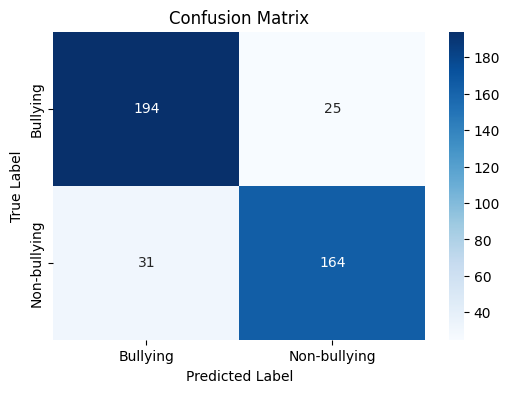

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred = (final_model.predict(X_test_pad) > 0.5).astype("int32")

# Classification Report (4 angka desimal)
class_names = le.inverse_transform([0, 1])
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ✅ Save model ke format .h5

In [25]:
final_model.save("final_model.h5")
print("Model berhasil disimpan ke final_model.h5")

Model berhasil disimpan ke final_model.h5


In [26]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


# ✅ Save tokenizer

In [29]:
import pickle

with open("tokenizer_2.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer berhasil disimpan ke tokenizer.pkl")

Tokenizer berhasil disimpan ke tokenizer.pkl


# Skenario 1: inference per sample (real-time)

# 11 sampel data :

In [36]:
import time
import numpy as np
single_sample = X_test_pad[0:11]
start = time.time()
_ = final_model.predict(single_sample)
end = time.time()
print(f"⏱️ Latency 11 sample: {(end - start)*1000:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
⏱️ Latency 11 sample: 72.85 ms


In [37]:
import time
import numpy as np
single_sample = X_test_pad[0:1]
start = time.time()
_ = final_model.predict(single_sample)
end = time.time()
print(f"⏱️ Latency 1 sample: {(end - start)*1000:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
⏱️ Latency 1 sample: 105.54 ms


# Skenario 2: inference batch penuh (throughput)

In [32]:
start = time.time()
_ = final_model.predict(X_test_pad, batch_size=best_params["batch_size"])
end = time.time()
print(f"⏱️ Latency batch penuh: {(end - start):.4f} detik")
print(f"Throughput: {len(X_test_pad) / (end - start):.2f} samples/detik")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
⏱️ Latency batch penuh: 0.1854 detik
Throughput: 2233.61 samples/detik


# Skenario 3: rata-rata latency beberapa sample

In [34]:
n_trials = 100
times = []
for i in np.random.choice(len(X_test_pad), n_trials, replace=False):
  sample = X_test_pad[i:i+1]
  t0 = time.time()
  _ = final_model.predict(sample, verbose=0)
  t1 = time.time()
  times.append((t1 - t0) * 1000)

  print(f"⏱️ Latency rata-rata (100 sample): {np.mean(times):.2f} ms ± {np.std(times):.2f} ms")

⏱️ Latency rata-rata (100 sample): 66.33 ms ± 0.00 ms
⏱️ Latency rata-rata (100 sample): 63.85 ms ± 2.47 ms
⏱️ Latency rata-rata (100 sample): 62.12 ms ± 3.17 ms
⏱️ Latency rata-rata (100 sample): 61.03 ms ± 3.33 ms
⏱️ Latency rata-rata (100 sample): 61.46 ms ± 3.10 ms
⏱️ Latency rata-rata (100 sample): 61.22 ms ± 2.88 ms
⏱️ Latency rata-rata (100 sample): 62.49 ms ± 4.09 ms
⏱️ Latency rata-rata (100 sample): 61.92 ms ± 4.11 ms
⏱️ Latency rata-rata (100 sample): 62.83 ms ± 4.65 ms
⏱️ Latency rata-rata (100 sample): 62.96 ms ± 4.43 ms
⏱️ Latency rata-rata (100 sample): 62.81 ms ± 4.25 ms
⏱️ Latency rata-rata (100 sample): 62.65 ms ± 4.10 ms
⏱️ Latency rata-rata (100 sample): 67.29 ms ± 16.55 ms
⏱️ Latency rata-rata (100 sample): 75.16 ms ± 32.55 ms
⏱️ Latency rata-rata (100 sample): 84.52 ms ± 47.07 ms
⏱️ Latency rata-rata (100 sample): 88.41 ms ± 47.99 ms
⏱️ Latency rata-rata (100 sample): 93.18 ms ± 50.32 ms
⏱️ Latency rata-rata (100 sample): 97.00 ms ± 51.38 ms
⏱️ Latency rata-rata (

In [38]:
!git clone https://github.com/WilliamAxelC/Indonesian-Cyberbullying-Detection-with-Distilbert.git


Cloning into 'Indonesian-Cyberbullying-Detection-with-Distilbert'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 141 (delta 68), reused 117 (delta 44), pack-reused 0 (from 0)
Receiving objects: 100% (141/141), 15.47 MiB | 25.34 MiB/s, done.
Resolving deltas: 100% (68/68), done.
